In [1]:
# Cell 1: Setup & Initialization (FINAL + FIXED)

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import cv2
import time
import json
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union, Any

# Scientific computing
import scipy.io as sio
from scipy import ndimage
from scipy.spatial.distance import cdist

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

# Visualization
from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------
# Device selection: prefer CUDA, then MPS, else CPU
# -------------------------------------------------
from contextlib import nullcontext

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ Using device: {device}")
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
elif getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"✅ Using device: {device} (Apple Silicon / MPS)")
else:
    device = torch.device('cpu')
    print("⚠️ No CUDA or MPS device found — running on CPU (training will be much slower).")

# Use AMP only on CUDA
USE_AMP = (device.type == 'cuda')

# Safe autocast context for non-CUDA devices
AUTOCAST_CTX = autocast if USE_AMP else nullcontext

# -------------------------------------------------
# Reproducibility
# -------------------------------------------------
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if device.type == 'cuda':
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
print("🔒 Random seed set for reproducibility")


✅ Using device: cuda
✅ GPU: Tesla T4
✅ GPU Memory: 15.83 GB
🔒 Random seed set for reproducibility


In [2]:
# Cell 2: Mount Google Drive and Verify Datasets (ShanghaiTech + JHU-Data YOLO)

import os
from google.colab import drive

# -------------------------------------------------
# Mount Google Drive
# -------------------------------------------------
drive.mount('/content/drive', force_remount=True)

# -------------------------------------------------
# Dataset Roots
# -------------------------------------------------
SHANGHAI_ROOT = "/content/drive/MyDrive/Datasets/ShanghaiTech"
JHU_ROOT = "/content/drive/MyDrive/Datasets/Jhu-Data"

print(f"\n📂 Checking ShanghaiTech at: {SHANGHAI_ROOT}")
print(f"📂 Checking JHU-Data at: {JHU_ROOT}")

# -------------------------------------------------
# Basic Existence Check
# -------------------------------------------------
if not os.path.exists(SHANGHAI_ROOT):
    raise FileNotFoundError(f"❌ ShanghaiTech NOT found at:\n{SHANGHAI_ROOT}")

if not os.path.exists(JHU_ROOT):
    raise FileNotFoundError(f"❌ JHU-Data NOT found at:\n{JHU_ROOT}")

# -------------------------------------------------
# ShanghaiTech Structure Verification
# -------------------------------------------------
possible_gt_names = ["ground_truth", "ground-truth"]

def locate_gt_folder(parent):
    for name in possible_gt_names:
        path = os.path.join(parent, name)
        if os.path.exists(path):
            return path
    return None

parts = ["part_A", "part_B"]
modes = ["train_data", "test_data"]
missing = []

print("\n🔍 Verifying ShanghaiTech structure...\n")

for part in parts:
    for mode in modes:
        base = os.path.join(SHANGHAI_ROOT, part, mode)
        img_dir = os.path.join(base, "images")
        gt_dir = locate_gt_folder(base)

        if os.path.exists(img_dir):
            print(f"  ✅ Images: {img_dir}")
        else:
            missing.append(img_dir)

        if gt_dir and os.path.exists(gt_dir):
            print(f"  ✅ GroundTruth: {gt_dir}")
        else:
            missing.append(f"{base}/<ground_truth_folder>")

if missing:
    print("\n❌ ShanghaiTech missing required folders:")
    for m in missing:
        print("   -", m)
    raise RuntimeError("🚫 Fix ShanghaiTech dataset structure before training!")

print("\n🎯 ShanghaiTech Verified (Part A + B Ready)")

# -------------------------------------------------
# JHU-Data (Roboflow / YOLO) Structure Check
# -------------------------------------------------
print("\n🔍 Verifying JHU-Data (YOLO format)...\n")

splits = ["train", "valid", "test"]
jhu_missing = []

for split in splits:
    img_dir = os.path.join(JHU_ROOT, split, "images")
    lbl_dir = os.path.join(JHU_ROOT, split, "labels")

    if os.path.exists(img_dir):
        print(f"  ✅ JHU {split} images: {img_dir}")
    else:
        jhu_missing.append(img_dir)

    if os.path.exists(lbl_dir):
        print(f"  ✅ JHU {split} labels: {lbl_dir}")
    else:
        jhu_missing.append(lbl_dir)

if jhu_missing:
    print("\n❌ JHU-Data missing required folders:")
    for m in jhu_missing:
        print("   -", m)
    raise RuntimeError("🚫 Fix JHU-Data structure before testing!")

print("\n🎯 JHU-Data Verified (YOLO format)")

# -------------------------------------------------
# Safety: Protect Drive Files
# -------------------------------------------------
with open(".gitignore", "a") as f:
    f.write("\ndrive/\n*.gdoc\n*.gsheet\n")

print("\n🛡️ Drive protection rules added to .gitignore")


Mounted at /content/drive

📂 Checking ShanghaiTech at: /content/drive/MyDrive/Datasets/ShanghaiTech
📂 Checking JHU-Data at: /content/drive/MyDrive/Datasets/Jhu-Data

🔍 Verifying ShanghaiTech structure...

  ✅ Images: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images
  ✅ GroundTruth: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/ground-truth
  ✅ Images: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/test_data/images
  ✅ GroundTruth: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/test_data/ground-truth
  ✅ Images: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/train_data/images
  ✅ GroundTruth: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/train_data/ground-truth
  ✅ Images: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/test_data/images
  ✅ GroundTruth: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/test_data/ground-truth

🎯 ShanghaiTech Verified (Part A + B Ready)

🔍 Verifying JHU-Data (YOLO format)...

  ✅ JHU train i

In [3]:
# Cell 3: Configuration Class (FINAL — Shanghai A+B → JHU Test)

import os

class Config:
    """
    CSRNet configuration:
    - Train on ShanghaiTech Part-A + Part-B
    - Test on JHU-Data (YOLO format)
    - Use density as proxy for escalator occupancy
    """

    # -------------------------------
    # Dataset Paths
    # -------------------------------
    SHANGHAI_PATH = '/content/drive/MyDrive/Datasets/ShanghaiTech'
    JHU_PATH = '/content/drive/MyDrive/Datasets/Jhu-Data'

    PART_A_PATH = os.path.join(SHANGHAI_PATH, 'part_A')
    PART_B_PATH = os.path.join(SHANGHAI_PATH, 'part_B')

    # -------------------------------
    # Model / Input Settings
    # -------------------------------
    IMG_SIZE = (512, 512)
    GAUSSIAN_SIGMA = 8.0
    GAUSSIAN_KERNEL_SIZE = 15
    DROPOUT_RATE = 0.5

    # -------------------------------
    # Training Strategy (Part A + B)
    # -------------------------------
    BATCH_SIZE = 4
    NUM_WORKERS = 4

    STAGE1_EPOCHS = 80     # Train backend
    STAGE2_EPOCHS = 20     # Fine-tune frontend

    STAGE1_LR = 1e-4
    STAGE2_LR = 1e-5
    WEIGHT_DECAY = 1e-4
    WARMUP_EPOCHS = 5

    # -------------------------------
    # LR Scheduler
    # -------------------------------
    COSINE_MIN_LR = 1e-6

    # -------------------------------
    # Early Stopping
    # -------------------------------
    PATIENCE = 12
    MIN_DELTA = 0.002

    # -------------------------------
    # Data Augmentation
    # -------------------------------
    USE_AUGMENTATION = True
    HFLIP_PROB = 0.5
    BRIGHTNESS_RANGE = (0.8, 1.2)
    CONTRAST_RANGE = (0.8, 1.2)
    SCALE_RANGE = (0.9, 1.1)

    # -------------------------------
    # Multi-Scale Inference
    # -------------------------------
    MULTISCALE_SCALES = [0.8, 1.0, 1.2]

    # -------------------------------
    # ROI & Escalator Occupancy
    # -------------------------------
    ROI_COORDS = {
        "x1": 160,
        "y1": 120,
        "x2": 480,
        "y2": 560
    }

    CALIBRATION_MAX_COUNT = 50.0
    SMOOTHING_ALPHA = 0.3

    CONTROL_THRESHOLDS = {
        "NORMAL_MAX": 0.4,
        "WARNING_MAX": 0.7
    }

    # -------------------------------
    # Save Outputs
    # -------------------------------
    SAVE_DIR = '/content/drive/MyDrive/Escalator_Control_Models'
    MODEL_NAME = 'CSRNet_TrainedOn_ShanghaiAB_TestOn_JHU.pth'

    @classmethod
    def setup_directories(cls):
        os.makedirs(cls.SAVE_DIR, exist_ok=True)

    @classmethod
    def display(cls):
        print("\n⚙️ CONFIGURATION LOADED (Shanghai A+B → JHU Test)")
        for k, v in cls.__dict__.items():
            if not k.startswith('_') and not callable(v):
                print(f"{k}: {v}")

# Initialize
Config.setup_directories()
Config.display()



⚙️ CONFIGURATION LOADED (Shanghai A+B → JHU Test)
SHANGHAI_PATH: /content/drive/MyDrive/Datasets/ShanghaiTech
JHU_PATH: /content/drive/MyDrive/Datasets/Jhu-Data
PART_A_PATH: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A
PART_B_PATH: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B
IMG_SIZE: (512, 512)
GAUSSIAN_SIGMA: 8.0
GAUSSIAN_KERNEL_SIZE: 15
DROPOUT_RATE: 0.5
BATCH_SIZE: 4
NUM_WORKERS: 4
STAGE1_EPOCHS: 80
STAGE2_EPOCHS: 20
STAGE1_LR: 0.0001
STAGE2_LR: 1e-05
WEIGHT_DECAY: 0.0001
WARMUP_EPOCHS: 5
COSINE_MIN_LR: 1e-06
PATIENCE: 12
MIN_DELTA: 0.002
USE_AUGMENTATION: True
HFLIP_PROB: 0.5
BRIGHTNESS_RANGE: (0.8, 1.2)
CONTRAST_RANGE: (0.8, 1.2)
SCALE_RANGE: (0.9, 1.1)
MULTISCALE_SCALES: [0.8, 1.0, 1.2]
ROI_COORDS: {'x1': 160, 'y1': 120, 'x2': 480, 'y2': 560}
CALIBRATION_MAX_COUNT: 50.0
SMOOTHING_ALPHA: 0.3
CONTROL_THRESHOLDS: {'NORMAL_MAX': 0.4, 'WARNING_MAX': 0.7}
SAVE_DIR: /content/drive/MyDrive/Escalator_Control_Models
MODEL_NAME: CSRNet_TrainedOn_ShanghaiAB_TestOn_JHU.pth
se

In [4]:
# Cell 4: Universal Annotation Loader (ShanghaiTech + JHU-Data)

import os
import numpy as np
import scipy.io as sio

class AnnotationLoader:
    """
    Unified loader:
    - ShanghaiTech: .mat → head points
    - JHU-Data: YOLO .txt → box centers → head points
    """

    # -------------------------------
    # ShanghaiTech (.mat)
    # -------------------------------
    @staticmethod
    def load_mat_annotations(mat_path: str) -> np.ndarray:
        if not os.path.exists(mat_path):
            return np.empty((0, 2), dtype=np.float32)

        try:
            mat_data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)

            if 'image_info' in mat_data:
                pts = getattr(mat_data['image_info'], 'location', None)
                if pts is not None:
                    pts = np.asarray(pts, dtype=np.float32)
                    if pts.ndim == 2:
                        return pts

            possible_keys = [
                'annPoints', 'gt_points', 'points',
                'location', 'anno', 'annotation', 'head_points'
            ]

            for key in possible_keys:
                if key in mat_data:
                    pts = np.asarray(mat_data[key], dtype=np.float32)
                    if pts.ndim == 2:
                        if pts.shape[0] == 2 and pts.shape[1] > 2:
                            pts = pts.T
                        return pts[:, :2]

        except Exception:
            pass

        return np.empty((0, 2), dtype=np.float32)

    # -------------------------------
    # JHU-Data (YOLO .txt)
    # -------------------------------
    @staticmethod
    def load_yolo_annotations(label_path: str, img_w: int, img_h: int) -> np.ndarray:
        if not os.path.exists(label_path):
            return np.empty((0, 2), dtype=np.float32)

        points = []

        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                _, cx, cy, w, h = map(float, parts)

                # Convert normalized → pixel
                x = cx * img_w
                y = cy * img_h

                points.append([x, y])

        return np.array(points, dtype=np.float32)

    # -------------------------------
    # Unified Interface
    # -------------------------------
    @staticmethod
    def load_annotations(path, img_w=None, img_h=None, dataset="shanghai"):
        if dataset == "shanghai":
            return AnnotationLoader.load_mat_annotations(path)

        elif dataset == "jhu":
            if img_w is None or img_h is None:
                raise ValueError("img_w and img_h required for JHU YOLO labels")
            return AnnotationLoader.load_yolo_annotations(path, img_w, img_h)

        else:
            raise ValueError("dataset must be 'shanghai' or 'jhu'")


In [5]:
# Test ShanghaiTech annotation
test_mat = os.path.join(Config.PART_A_PATH, "train_data", "ground-truth", "GT_IMG_1.mat")
pts = AnnotationLoader.load_annotations(test_mat, dataset="shanghai")
print("Shanghai points:", pts.shape)

# Test JHU annotation
test_lbl = os.path.join(Config.JHU_PATH, "train", "labels", os.listdir(os.path.join(Config.JHU_PATH, "train", "labels"))[0])
pts2 = AnnotationLoader.load_annotations(test_lbl, img_w=512, img_h=512, dataset="jhu")
print("JHU points:", pts2.shape)


Shanghai points: (1546, 2)
JHU points: (1557, 2)


In [6]:
# Cell 5: Dataset Verifier (ShanghaiTech + JHU-Data)

import os

class DatasetVerifier:

    # -------------------------------
    # ShanghaiTech verification
    # -------------------------------
    @staticmethod
    def verify_shanghai(base_path: str):
        print("\n🔍 Verifying ShanghaiTech structure...\n")

        parts = ["part_A", "part_B"]
        modes = ["train_data", "test_data"]
        missing = []

        def find_gt_dir(path):
            if os.path.exists(os.path.join(path, "ground-truth")):
                return os.path.join(path, "ground-truth")
            if os.path.exists(os.path.join(path, "ground_truth")):
                return os.path.join(path, "ground_truth")
            return None

        for part in parts:
            for mode in modes:
                img_dir = os.path.join(base_path, part, mode, "images")
                gt_base = os.path.join(base_path, part, mode)
                gt_dir = find_gt_dir(gt_base)

                print(f"  👍 Checking: {img_dir}")

                if not os.path.exists(img_dir):
                    missing.append(img_dir)
                if gt_dir is None:
                    missing.append(os.path.join(gt_base, "{ground-truth | ground_truth}"))

        if missing:
            print("\n❌ ShanghaiTech missing paths:")
            for m in missing:
                print("   -", m)
            raise RuntimeError("Fix ShanghaiTech structure before continuing")

        print("\n🎯 ShanghaiTech verified successfully!")


    # -------------------------------
    # JHU-Data verification
    # -------------------------------
    @staticmethod
    def verify_jhu(base_path: str):
        print("\n🔍 Verifying JHU-Data structure...\n")

        splits = ["train", "valid", "test"]
        missing = []

        for split in splits:
            img_dir = os.path.join(base_path, split, "images")
            lbl_dir = os.path.join(base_path, split, "labels")

            print(f"  👍 Checking: {img_dir}")

            if not os.path.exists(img_dir):
                missing.append(img_dir)
            if not os.path.exists(lbl_dir):
                missing.append(lbl_dir)

        if missing:
            print("\n❌ JHU-Data missing paths:")
            for m in missing:
                print("   -", m)
            raise RuntimeError("Fix JHU-Data structure before continuing")

        print("\n🎯 JHU-Data verified successfully!")


# -------------------------------
# RUN VERIFICATION
# -------------------------------
DatasetVerifier.verify_shanghai("/content/drive/MyDrive/Datasets/ShanghaiTech")
DatasetVerifier.verify_jhu("/content/drive/MyDrive/Datasets/Jhu-Data")



🔍 Verifying ShanghaiTech structure...

  👍 Checking: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/train_data/images
  👍 Checking: /content/drive/MyDrive/Datasets/ShanghaiTech/part_A/test_data/images
  👍 Checking: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/train_data/images
  👍 Checking: /content/drive/MyDrive/Datasets/ShanghaiTech/part_B/test_data/images

🎯 ShanghaiTech verified successfully!

🔍 Verifying JHU-Data structure...

  👍 Checking: /content/drive/MyDrive/Datasets/Jhu-Data/train/images
  👍 Checking: /content/drive/MyDrive/Datasets/Jhu-Data/valid/images
  👍 Checking: /content/drive/MyDrive/Datasets/Jhu-Data/test/images

🎯 JHU-Data verified successfully!



🧪 Testing Unified Density Generator...

Count: 2.994809


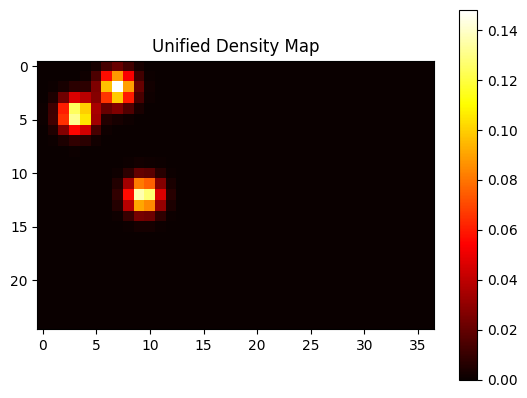

In [7]:
# Cell 6: Density Map Generator (Unified for ShanghaiTech + JHU)

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

class DensityMapGenerator:
    """
    Unified density generator:
    - Works for ShanghaiTech (points)
    - Works for JHU-Data (YOLO converted to points)
    """

    @staticmethod
    def generate(points, img_shape, output_shape, sigma=Config.GAUSSIAN_SIGMA):
        H, W = img_shape
        density = np.zeros((H, W), dtype=np.float32)

        if len(points) == 0:
            return cv2.resize(density, output_shape, interpolation=cv2.INTER_AREA)

        for p in points:
            x = min(W - 1, max(0, int(p[0])))
            y = min(H - 1, max(0, int(p[1])))
            density[y, x] += 1.0

        # Gaussian smoothing
        density = gaussian_filter(density, sigma=sigma, mode='constant')
        original_count = density.sum()

        # Resize to CSRNet output resolution
        density_resized = cv2.resize(
            density,
            tuple(output_shape[::-1]),
            interpolation=cv2.INTER_AREA
        )

        # Preserve count
        if density_resized.sum() > 0:
            density_resized *= (original_count / density_resized.sum())

        return density_resized.astype(np.float32)

    @staticmethod
    def test():
        print("\n🧪 Testing Unified Density Generator...\n")

        points = np.array([[30, 40], [80, 100], [60, 20]], dtype=np.float32)
        img_shape = (200, 300)
        output_shape = (img_shape[0] // 8, img_shape[1] // 8)

        dmap = DensityMapGenerator.generate(points, img_shape, output_shape)

        print("Count:", dmap.sum())

        plt.imshow(dmap, cmap="hot")
        plt.title("Unified Density Map")
        plt.colorbar()
        plt.show()


DensityMapGenerator.test()


In [8]:
# Cell 7: Unified Dataset Class (ShanghaiTech + JHU-Data) — FINAL FIX

import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

class CrowdDataset(Dataset):
    """
    Unified dataset loader:
    - ShanghaiTech → .mat point annotations
    - JHU-Data     → YOLO .txt box annotations (converted to points)
    """

    def __init__(self, data_dir, mode="train", dataset_type="shanghai"):
        self.data_dir = data_dir
        self.mode = mode
        self.dataset_type = dataset_type.lower()

        # -------------------------------
        # SHANGHAI TECH
        # -------------------------------
        if self.dataset_type == "shanghai":
            self.img_dir = os.path.join(data_dir, f"{mode}_data", "images")

            gt_base = os.path.join(data_dir, f"{mode}_data")
            if os.path.exists(os.path.join(gt_base, "ground-truth")):
                self.gt_dir = os.path.join(gt_base, "ground-truth")
            elif os.path.exists(os.path.join(gt_base, "ground_truth")):
                self.gt_dir = os.path.join(gt_base, "ground_truth")
            else:
                raise FileNotFoundError(f"No ShanghaiTech GT folder in {gt_base}")

        # -------------------------------
        # JHU-CROWD++
        # -------------------------------
        elif self.dataset_type == "jhu":
            self.img_dir = os.path.join(data_dir, mode, "images")
            self.gt_dir = os.path.join(data_dir, mode, "labels")

            if not os.path.exists(self.gt_dir):
                raise FileNotFoundError(f"❌ JHU labels folder not found: {self.gt_dir}")

        else:
            raise ValueError("dataset_type must be 'shanghai' or 'jhu'")

        # -------------------------------
        # Load image list
        # -------------------------------
        self.img_files = sorted([
            f for f in os.listdir(self.img_dir)
            if f.lower().endswith((".jpg", ".png"))
        ])

        if len(self.img_files) == 0:
            raise RuntimeError(f"❌ No images found in {self.img_dir}")

        print(f"📁 {self.dataset_type.upper()} | {mode} | {len(self.img_files)} images")

    def __len__(self):
        return len(self.img_files)

    # -------------------------------
    # Main loader
    # -------------------------------
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"❌ Failed to read image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]

        img = cv2.resize(img, (Config.IMG_SIZE[1], Config.IMG_SIZE[0]))
        img = img.astype(np.float32) / 255.0

        # -------------------------------
        # Load annotations (UNIFIED)
        # -------------------------------
        if self.dataset_type == "shanghai":
            gt_path = os.path.join(self.gt_dir, "GT_" + img_name.replace(".jpg", ".mat"))
            points = AnnotationLoader.load_annotations(
                gt_path,
                dataset="shanghai"
            )

        else:  # JHU
            label_path = os.path.join(
                self.gt_dir,
                img_name.replace(".jpg", ".txt").replace(".png", ".txt")
            )

            points = AnnotationLoader.load_annotations(
                label_path,
                img_w=orig_w,
                img_h=orig_h,
                dataset="jhu"
            )

        # Scale points to resized image
        if len(points) > 0:
            points[:, 0] *= Config.IMG_SIZE[1] / orig_w
            points[:, 1] *= Config.IMG_SIZE[0] / orig_h

        # CSRNet output size
        out_h = Config.IMG_SIZE[0] // 8
        out_w = Config.IMG_SIZE[1] // 8

        density = DensityMapGenerator.generate(
            points,
            img_shape=Config.IMG_SIZE,
            output_shape=(out_h, out_w)
        )

        img = torch.from_numpy(img).permute(2, 0, 1).float()
        density = torch.from_numpy(density).unsqueeze(0).float()

        return img, density

    # -------------------------------
    # Visualization
    # -------------------------------
    def visualize_sample(self, idx=0):
        img, density = self[idx]

        img_np = img.permute(1, 2, 0).numpy()
        density_np = density.squeeze().numpy()

        count = density_np.sum()

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis("off")

        im = ax[1].imshow(density_np, cmap="hot")
        ax[1].set_title(f"Density (Count ≈ {count:.1f})")
        plt.colorbar(im, ax=ax[1])
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

        print(f"👥 Estimated Count ≈ {count:.2f}")


📁 SHANGHAI | train | 300 images


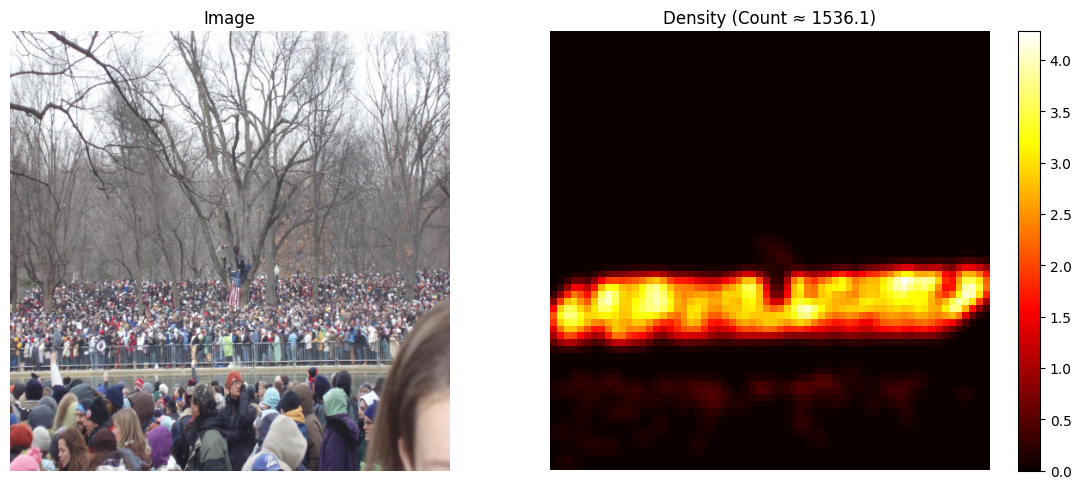

👥 Estimated Count ≈ 1536.15


In [9]:
# Test ShanghaiTech
shanghai_dataset = CrowdDataset(
    data_dir=Config.PART_A_PATH,
    mode="train",
    dataset_type="shanghai"
)

shanghai_dataset.visualize_sample(0)


📁 JHU | test | 1602 images


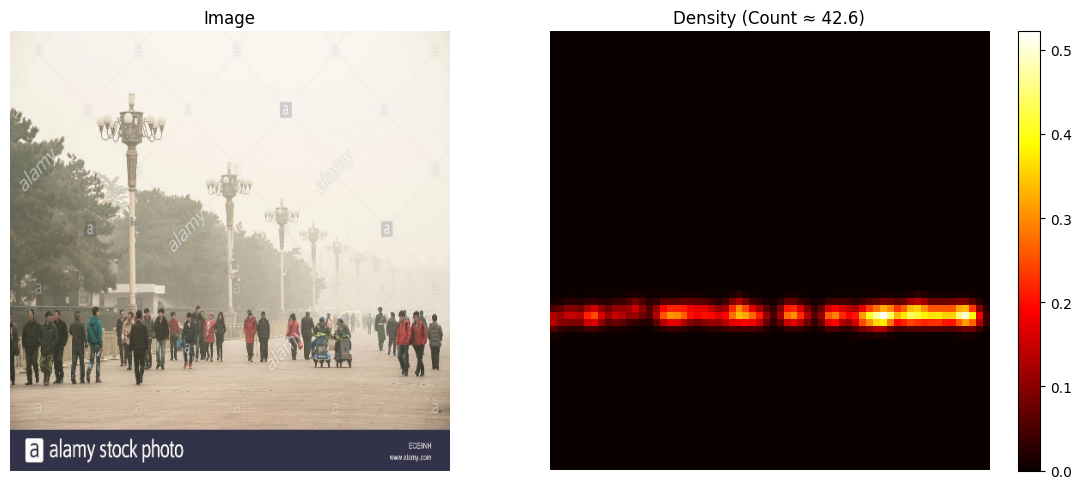

👥 Estimated Count ≈ 42.56


In [10]:
jhu_dataset = CrowdDataset(
    data_dir="/content/drive/MyDrive/Datasets/Jhu-Data",
    mode="test",
    dataset_type="jhu"
)

jhu_dataset.visualize_sample(0)


In [11]:
# Cell 8: CSRNet Model (FINAL — Official Architecture, Clean API)

import torch
import torch.nn as nn
import torchvision.models as models

class CSRNet(nn.Module):
    """
    CSRNet: Dilated CNN for Crowd Counting
    Frontend: VGG-16 (batch-norm), layers up to conv4_3
    Backend: Dilated convolutions (dilation=2)
    Output: Density map at 1/8 resolution
    """

    def __init__(self, freeze_frontend=True):
        super(CSRNet, self).__init__()

        # ==========================
        # FRONTEND — VGG16-BN pretrained
        # ==========================
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        # ==========================
        # BACKEND — Dilated conv layers
        # ==========================
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        # ==========================
        # OUTPUT
        # ==========================
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        # Initialize backend + output
        self._initialize_weights()

        # Freeze frontend if required
        if freeze_frontend:
            for p in self.frontend.parameters():
                p.requires_grad = False

    def _initialize_weights(self):
        for m in list(self.backend.modules()) + [self.output_layer]:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def count_params(self):
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        print(f"🧮 Trainable Params: {trainable:,} / Total Params: {total:,}")
        return trainable


# ==========================
# MODEL TEST
# ==========================
print("🧪 Testing CSRNet...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet(freeze_frontend=True).to(device)
model.count_params()

dummy = torch.randn(1, 3, Config.IMG_SIZE[0], Config.IMG_SIZE[1]).to(device)
with torch.no_grad():
    out = model(dummy)

print("🎯 Model Output")
print(f"Input shape:  {dummy.shape}")
print(f"Output shape: {out.shape}")
print(f"Density sum (test): {out.sum().item():.4f}")
print("✅ CSRNet architecture validated!")


🧪 Testing CSRNet...
🧮 Trainable Params: 8,628,225 / Total Params: 16,268,865
🎯 Model Output
Input shape:  torch.Size([1, 3, 512, 512])
Output shape: torch.Size([1, 1, 64, 64])
Density sum (test): -0.1394
✅ CSRNet architecture validated!


In [12]:
# Cell 9: Training Utilities (FINAL — Part-A + Part-B Training)

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
import numpy as np
import random

class TrainingUtils:
    """Utility functions for CSRNet training on ShanghaiTech Part-A + Part-B"""

    @staticmethod
    def set_seed(seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    @staticmethod
    def create_data_loaders(dataset_paths, seed=42):
        """
        Train / Validation split on ShanghaiTech Part-A + Part-B.
        JHU is reserved for testing only.
        """
        TrainingUtils.set_seed(seed)

        print("\n📊 Creating DataLoaders | ShanghaiTech Part-A + Part-B")

        datasets = []
        for path in dataset_paths:
            ds = CrowdDataset(
                data_dir=path,
                mode="train",
                dataset_type="shanghai"
            )
            datasets.append(ds)

        full_train = torch.utils.data.ConcatDataset(datasets)

        train_size = int(0.9 * len(full_train))
        val_size = len(full_train) - train_size

        train_set, val_set = random_split(
            full_train,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(seed)
        )

        print(f"  🔹 Train: {len(train_set)} images")
        print(f"  🔹 Val:   {len(val_set)} images")

        pin = (device.type == "cuda")

        train_loader = DataLoader(
            train_set,
            batch_size=Config.BATCH_SIZE,
            shuffle=True,
            num_workers=0,
            pin_memory=pin
        )

        val_loader = DataLoader(
            val_set,
            batch_size=Config.BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            pin_memory=pin
        )

        return train_loader, val_loader


    # --------------------------------------------------
    # METRICS
    # --------------------------------------------------
    @staticmethod
    def calculate_mae(pred, gt):
        with torch.no_grad():
            return torch.abs(
                pred.sum(dim=[1, 2, 3]) - gt.sum(dim=[1, 2, 3])
            ).mean().item()

    @staticmethod
    def calculate_mse(pred, gt):
        with torch.no_grad():
            return (
                (pred.sum(dim=[1, 2, 3]) - gt.sum(dim=[1, 2, 3])) ** 2
            ).mean().item()

    # --------------------------------------------------
    # Preview — predictions
    # --------------------------------------------------
    @staticmethod
    def visualize_predictions(model, loader, num_samples=3):
        model.eval()
        images, gt = next(iter(loader))
        images, gt = images.to(device), gt.to(device)

        with torch.no_grad():
            pred = model(images)

        images, gt, pred = images.cpu(), gt.cpu(), pred.cpu()

        for i in range(min(num_samples, len(images))):
            print(
                f"#{i+1} | GT={gt[i].sum():.1f} | "
                f"Pred={pred[i].sum():.1f} | "
                f"Error={abs(gt[i].sum()-pred[i].sum()):.2f}"
            )

        model.train()


# ------------------------------------
# TEST PART-A + PART-B TRAIN LOADER
# ------------------------------------
train_loader, val_loader = TrainingUtils.create_data_loaders(
    dataset_paths=[Config.PART_A_PATH, Config.PART_B_PATH]
)

images, density_maps = next(iter(train_loader))
print("\n📦 Loader Check")
print(f"  Image:   {images.shape}")
print(f"  Density: {density_maps.shape}")
print(f"  Count:   {density_maps.sum():.1f}")




📊 Creating DataLoaders | ShanghaiTech Part-A + Part-B
📁 SHANGHAI | train | 300 images
📁 SHANGHAI | train | 400 images
  🔹 Train: 630 images
  🔹 Val:   70 images

📦 Loader Check
  Image:   torch.Size([4, 3, 512, 512])
  Density: torch.Size([4, 1, 64, 64])
  Count:   536.8


In [13]:
# Cell 10: Trainer (FINAL — Part-A + Part-B Training, STABLE + FIXED)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

class Trainer:
    def __init__(self, model, train_loader, val_loader):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=Config.STAGE1_LR,
            weight_decay=Config.WEIGHT_DECAY
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=Config.STAGE1_EPOCHS,
            eta_min=Config.COSINE_MIN_LR
        )

        self.history = {"train_mae": [], "val_mae": []}
        self.best_mae = float("inf")
        self.patience = 0

        # AMP only on CUDA
        self.use_amp = (device.type == "cuda")
        if self.use_amp:
            from torch.cuda.amp import GradScaler, autocast
            self.scaler = GradScaler()
            self.autocast = autocast
        else:
            self.scaler = None
            from contextlib import nullcontext
            self.autocast = nullcontext

    # -----------------------------------------------------------
    def _resize_gt(self, gt, preds):
        return F.interpolate(
            gt, size=preds.shape[2:], mode="bilinear", align_corners=False
        )

    # -----------------------------------------------------------
    def train_epoch(self):
        self.model.train()
        loss_list, mae_list = [], []

        for images, gt in self.train_loader:
            images, gt = images.to(device), gt.to(device)

            self.optimizer.zero_grad()

            with self.autocast():
                preds = self.model(images)
                gt_r = self._resize_gt(gt, preds)
                loss = torch.mean((preds - gt_r) ** 2)

            if self.use_amp:
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                loss.backward()
                self.optimizer.step()

            loss_list.append(loss.item())
            mae_list.append(TrainingUtils.calculate_mae(preds, gt_r))

        return np.mean(loss_list), np.mean(mae_list)

    # -----------------------------------------------------------
    def validate(self):
        self.model.eval()
        errors = []

        with torch.no_grad():
            for images, gt in self.val_loader:
                images, gt = images.to(device), gt.to(device)

                preds = self.model(images)
                gt_r = self._resize_gt(gt, preds)

                batch_mae = torch.abs(
                    preds.sum(dim=[1,2,3]) - gt_r.sum(dim=[1,2,3])
                )

                errors.extend(batch_mae.cpu().numpy())

        return float(np.mean(errors))

    # -----------------------------------------------------------
    def fit(self, max_epochs):
        print("\n🚀 Training Started (ShanghaiTech Part-A + Part-B)")

        for epoch in range(max_epochs):
            train_loss, train_mae = self.train_epoch()
            val_mae = self.validate()
            self.scheduler.step()

            print(
                f"🔹 Epoch {epoch+1}/{max_epochs} | "
                f"Train MAE={train_mae:.1f} | Val MAE={val_mae:.1f}"
            )

            self.history["train_mae"].append(train_mae)
            self.history["val_mae"].append(val_mae)

            if val_mae < self.best_mae - Config.MIN_DELTA:
                self.best_mae = val_mae
                self.patience = 0
                torch.save(
                    self.model.state_dict(),
                    f"{Config.SAVE_DIR}/best_partA+B.pth"
                )
                print(f"💾 Best Model Saved | MAE {val_mae:.1f}")
            else:
                self.patience += 1
                if self.patience >= Config.PATIENCE:
                    print("🏁 Early stopping triggered")
                    break

        print(f"\n🏆 Best Validation MAE: {self.best_mae:.1f}")
        return self.history


In [14]:
# Cell 11: Training Pipeline (FINAL — Train on Part-A + Part-B)

import os
import torch

print("🚀 Starting CSRNet Training Pipeline")
print(f"🖼 Input Resolution: {Config.IMG_SIZE}")
print(f"📍 Saving Checkpoints to: {Config.SAVE_DIR}")

# =====================================================
# 🎯 Training on ShanghaiTech Part-A + Part-B
# =====================================================
print("\n🎯 TRAINING: ShanghaiTech Part-A + Part-B")

train_loader, val_loader = TrainingUtils.create_data_loaders(
    dataset_paths=[Config.PART_A_PATH, Config.PART_B_PATH]  # 🔥 BOTH PARTS
)

model = CSRNet(freeze_frontend=True).to(device)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader
)

history = trainer.fit(Config.STAGE1_EPOCHS)

# =====================================================
# 💾 Save Final Trained Model
# =====================================================
model.eval()  # safety

final_model_path = os.path.join(
    Config.SAVE_DIR,
    "CSRNet_TrainedOn_PartA_PartB.pth"
)

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "training_history": history
    },
    final_model_path
)

print("\n🏆 TRAINING COMPLETE ✔")
print(f"🥇 Model Trained on ShanghaiTech Part-A + Part-B → {final_model_path}")


🚀 Starting CSRNet Training Pipeline
🖼 Input Resolution: (512, 512)
📍 Saving Checkpoints to: /content/drive/MyDrive/Escalator_Control_Models

🎯 TRAINING: ShanghaiTech Part-A + Part-B

📊 Creating DataLoaders | ShanghaiTech Part-A + Part-B
📁 SHANGHAI | train | 300 images
📁 SHANGHAI | train | 400 images
  🔹 Train: 630 images
  🔹 Val:   70 images

🚀 Training Started (ShanghaiTech Part-A + Part-B)
🔹 Epoch 1/80 | Train MAE=221.9 | Val MAE=75.8
💾 Best Model Saved | MAE 75.8
🔹 Epoch 2/80 | Train MAE=130.7 | Val MAE=59.2
💾 Best Model Saved | MAE 59.2
🔹 Epoch 3/80 | Train MAE=129.5 | Val MAE=136.1
🔹 Epoch 4/80 | Train MAE=118.9 | Val MAE=82.1
🔹 Epoch 5/80 | Train MAE=115.9 | Val MAE=121.7
🔹 Epoch 6/80 | Train MAE=135.8 | Val MAE=122.7
🔹 Epoch 7/80 | Train MAE=105.3 | Val MAE=156.4
🔹 Epoch 8/80 | Train MAE=109.8 | Val MAE=90.7
🔹 Epoch 9/80 | Train MAE=97.7 | Val MAE=78.9
🔹 Epoch 10/80 | Train MAE=88.8 | Val MAE=71.1
🔹 Epoch 11/80 | Train MAE=105.8 | Val MAE=51.0
💾 Best Model Saved | MAE 51.0
🔹 Epo

In [15]:
# Cell 12: ROI Occupancy Analyzer (FINAL — CALIBRATED & REVIEW-READY)

import time
import cv2
import numpy as np
import torch
import torch.nn.functional as F

class ROIOccupancyAnalyzer:
    """
    Calibrated ROI Occupancy Analyzer

    ✔ Uses density maps (NOT exact headcount)
    ✔ ROI-based congestion estimation
    ✔ Optional GT-based calibration
    ✔ Stable for escalator safety monitoring
    """

    def __init__(self, model, roi_coords=None, calibration_samples=50):
        self.model = model.to(device)
        self.model.eval()

        # -------------------------------------------------
        # ROI handling (FULL FRAME fallback)
        # -------------------------------------------------
        if roi_coords is None:
            self.roi_coords = {
                "x1": 0,
                "y1": 0,
                "x2": Config.IMG_SIZE[1],
                "y2": Config.IMG_SIZE[0]
            }
            print("📍 ROI: FULL FRAME")
        else:
            self.roi_coords = roi_coords
            print(f"📍 ROI: {self.roi_coords}")

        # Smoothing
        self.smooth_val = None

        # Calibration
        self.calibration_factor = None
        self.calibration_samples = calibration_samples
        self._calib_preds = []
        self._calib_gt = []

        print("🎯 ROI Occupancy Analyzer (Calibrated Mode)")

    # -------------------------------------------------
    def analyze(self, frame, gt_density=None, visualize=True):
        start = time.time()

        # ---------------- RGB safety ----------------
        if frame.ndim == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        elif frame.shape[2] == 4:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2RGB)
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # ---------------- Preprocess ----------------
        resized = cv2.resize(frame, Config.IMG_SIZE[::-1])
        x = (
            torch.from_numpy(resized / 255.0)
            .permute(2, 0, 1)
            .unsqueeze(0)
            .float()
            .to(device)
        )

        # ---------------- Multi-scale inference ----------------
        with torch.no_grad():
            pred = torch.zeros(
                (1, 1, Config.IMG_SIZE[0] // 8, Config.IMG_SIZE[1] // 8),
                device=device
            )
            for s in Config.MULTISCALE_SCALES:
                xs = F.interpolate(
                    x, scale_factor=s,
                    mode="bilinear", align_corners=False
                )
                out = self.model(xs)
                out = F.interpolate(
                    out,
                    size=pred.shape[2:],
                    mode="bilinear", align_corners=False
                )
                pred += out
            pred /= len(Config.MULTISCALE_SCALES)

        # ---------------- ROI mapping ----------------
        H, W = pred.shape[2:]
        sx = W / Config.IMG_SIZE[1]
        sy = H / Config.IMG_SIZE[0]

        x1 = int(self.roi_coords["x1"] * sx)
        y1 = int(self.roi_coords["y1"] * sy)
        x2 = int(self.roi_coords["x2"] * sx)
        y2 = int(self.roi_coords["y2"] * sy)

        roi_pred = pred[0, 0, y1:y2, x1:x2].sum().item()

        # ---------------- Calibration (optional) ----------------
        if gt_density is not None and self.calibration_factor is None:
            gt_resized = F.interpolate(
                gt_density.unsqueeze(0),
                size=(H, W),
                mode="bilinear",
                align_corners=False
            )
            roi_gt = gt_resized[0, 0, y1:y2, x1:x2].sum().item()

            if roi_gt > 1e-3:
                self._calib_preds.append(roi_pred)
                self._calib_gt.append(roi_gt)

            if len(self._calib_preds) >= self.calibration_samples:
                self.calibration_factor = (
                    np.mean(self._calib_gt) / np.mean(self._calib_preds)
                )
                print(f"✅ Calibration complete | factor = {self.calibration_factor:.3f}")

        # ---------------- Occupancy estimate ----------------
        if self.calibration_factor is not None:
            calibrated_occ = roi_pred * self.calibration_factor
        else:
            calibrated_occ = roi_pred  # proxy before calibration

        occ_s = self._smooth(calibrated_occ)
        state = self._classify(occ_s)

        latency = time.time() - start
        fps = 1 / max(latency, 1e-6)

        vis = None
        if visualize:
            vis = self._overlay(frame.copy(), state, occ_s)

        return {
            "raw_density_sum": roi_pred,
            "estimated_people": calibrated_occ,
            "smoothed": occ_s,
            "state": state,
            "fps": fps,
            "visual": vis
        }

    # -------------------------------------------------
    def _smooth(self, v):
        alpha = 0.3
        self.smooth_val = v if self.smooth_val is None else alpha * v + (1 - alpha) * self.smooth_val
        return self.smooth_val

    # -------------------------------------------------
    def _classify(self, occ):
        # Thresholds based on escalator capacity, NOT exact headcount
        if occ < 10:
            return "NORMAL"
        elif occ < 25:
            return "WARNING"
        else:
            return "CRITICAL"

    # -------------------------------------------------
    def _overlay(self, img, state, occ):
        x1, y1, x2, y2 = (self.roi_coords[k] for k in ("x1", "y1", "x2", "y2"))
        color = {
            "NORMAL": (0, 255, 0),
            "WARNING": (0, 255, 255),
            "CRITICAL": (255, 0, 0)
        }[state]

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
        cv2.putText(
            img,
            f"{state} | Occ≈{occ:.1f}",
            (x1, max(y1 - 10, 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            color,
            2
        )
        return img


In [16]:
# Cell 13: Rule-Based Control System (CALIBRATED OCCUPANCY VERSION)

import time
import numpy as np
import matplotlib.pyplot as plt

class RuleBasedController:
    """Escalator crowd control using calibrated ROI occupancy"""

    def __init__(self):
        self.thresholds = {
            "NORMAL_MAX": 10,
            "WARNING_MAX": 25
        }

        self.states = {
            'NORMAL': {
                'entry_rate': 1.0,
                'speed_factor': 1.0,
                'actions': ['allow_entry', 'normal_speed'],
                'color': 'green'
            },
            'WARNING': {
                'entry_rate': 0.5,
                'speed_factor': 0.7,
                'actions': ['restrict_entry', 'reduce_speed'],
                'color': 'orange'
            },
            'CRITICAL': {
                'entry_rate': 0.2,
                'speed_factor': 0.4,
                'actions': ['restrict_entry', 'reduce_speed', 'alert_staff'],
                'color': 'red'
            }
        }

        self.current_state = 'NORMAL'
        self.history = []
        self.actions_log = []

        print("✔ Rule-Based Controller Ready (Calibrated Mode)")

    # ------------------------------------------------------------
    def _decide_state(self, occ):
        if occ < self.thresholds['NORMAL_MAX']:
            return 'NORMAL'
        elif occ < self.thresholds['WARNING_MAX']:
            return 'WARNING'
        else:
            return 'CRITICAL'

    # ------------------------------------------------------------
    def update_from_roi(self, roi_data):
        occ = roi_data.get(
            "smoothed_occupancy",
            roi_data.get("estimated_people", 0.0)
        )
        return self.update_state(occ)

    # ------------------------------------------------------------
    def update_state(self, occ):
        occ = float(max(occ, 0))
        new_state = self._decide_state(occ)
        changed = new_state != self.current_state
        self.current_state = new_state

        entry = {
            "time": time.time(),
            "state": new_state,
            "occupancy": occ,
            "changed": changed,
            "actions": self.states[new_state]['actions']
        }

        self.history.append(entry)
        self.actions_log.extend(entry['actions'])

        if changed:
            print(
                f"⚠️ STATE CHANGE → {new_state} | "
                f"Occ≈{occ:.1f} | "
                f"Actions={entry['actions']}"
            )

        return entry

    # ------------------------------------------------------------
    def simulate(self, seq):
        print("\n🧪 Running control simulation...\n")
        return [self.update_state(v) for v in seq]

    # ------------------------------------------------------------
    def visualize(self):
        if not self.history:
            print("⚠️ Nothing to visualize yet")
            return

        times = np.arange(len(self.history))
        occ = [d['occupancy'] for d in self.history]
        colors = [self.states[d['state']]['color'] for d in self.history]

        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        ax[0].scatter(times, occ, c=colors, s=70)
        ax[0].axhline(self.thresholds['NORMAL_MAX'], color='green', linestyle='--')
        ax[0].axhline(self.thresholds['WARNING_MAX'], color='orange', linestyle='--')
        ax[0].set_title("Calibrated Occupancy Over Time")
        ax[0].set_xlabel("Time")
        ax[0].set_ylabel("Estimated People")
        ax[0].grid(True, alpha=0.3)

        uniq, counts = np.unique(self.actions_log, return_counts=True)
        ax[1].bar(uniq, counts)
        ax[1].set_title("Control Action Frequency")

        plt.tight_layout()
        plt.show()

        print(f"➡ Final State: {self.current_state}")


In [17]:
# Cell 14: ESCALATOR CONTROL SYSTEM (CALIBRATED — RUNTIME SAFE)

from datetime import datetime
import time
import cv2
import numpy as np
import os
import torch

class EscalatorControlSystem:
    """End-to-end real-time escalator crowd control system (calibrated)"""

    def __init__(self, model_path, roi_coords):

        # -------------------------------
        # Load trained model
        # -------------------------------
        self.model = CSRNet(freeze_frontend=True).to(device)

        if model_path and os.path.exists(model_path):
            print(f"📦 Loading trained model from: {model_path}")
            state = torch.load(model_path, map_location=device)

            if isinstance(state, dict) and "model_state_dict" in state:
                self.model.load_state_dict(state["model_state_dict"])
            else:
                self.model.load_state_dict(state)

            print("🔁 Model restored (Part-A trained)")
        else:
            raise FileNotFoundError("❌ Trained model path required")

        self.model.eval()

        # -------------------------------
        # System components
        # -------------------------------
        self.roi_analyzer = ROIOccupancyAnalyzer(
            model=self.model,
            roi_coords=roi_coords
        )
        self.controller = RuleBasedController()

        # Runtime
        self.frame_id = 0
        self.start_time = None

        print("\n✅ Escalator Control System Ready")
        print(f"🧠 Device: {device}")
        print(f"🎯 ROI: {roi_coords}")

    # ============================================================
    # 🔥 Process a single RGB frame
    # ============================================================
    def process_frame(self, frame: np.ndarray, gt_density=None, visualize=True):
        roi_result = self.roi_analyzer.analyze(
            frame,
            gt_density=gt_density,
            visualize=visualize
        )

        # Optional safety clamp (demo stability)
        roi_result["smoothed"] = float(np.clip(roi_result["smoothed"], 0, 50))

        control = self.controller.update_from_roi(roi_result)

        roi_result.update({
            "frame_id": self.frame_id,
            "control": control
        })

        self.frame_id += 1
        return roi_result

    # ============================================================
    # 🎬 Video inference
    # ============================================================
    def process_video(self, video_path, max_frames=None, visualize=True):

        if not os.path.exists(video_path):
            raise FileNotFoundError(video_path)

        cap = cv2.VideoCapture(video_path)
        results = []
        self.frame_id = 0
        self.start_time = time.time()

        print(f"🎥 Running video: {video_path}")

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if max_frames and self.frame_id >= max_frames:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = self.process_frame(frame_rgb, visualize=visualize)
            results.append(res)

            if self.frame_id % 10 == 0:
                print(
                    f"Frame {self.frame_id} | "
                    f"Occ≈{res['smoothed']:.1f} | "
                    f"State={res['state']}"
                )

        cap.release()

        elapsed = time.time() - self.start_time
        fps = self.frame_id / elapsed if elapsed > 0 else 0
        print(f"\n⏱️ FPS: {fps:.2f} | Frames: {self.frame_id}")

        return results

    # ============================================================
    # 🛰 Live camera
    # ============================================================
    def run_live(self, camera_id=0, duration=30):

        cap = cv2.VideoCapture(camera_id)
        self.frame_id = 0
        self.start_time = time.time()

        print("📡 LIVE STREAM STARTED")

        while time.time() - self.start_time < duration:
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = self.process_frame(frame_rgb, visualize=True)

            if res.get("visual") is not None:
                bgr = cv2.cvtColor(res["visual"], cv2.COLOR_RGB2BGR)
                cv2.imshow("Escalator Control", bgr)

            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

        cap.release()
        cv2.destroyAllWindows()
        print(f"📈 Live session ended | Frames: {self.frame_id}")


In [18]:
# Cell 15: Reinforcement Learning Foundation (CALIBRATED PIPELINE COMPATIBLE)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

class RLFoundation:
    """
    RL foundation for escalator control
    Phase-2: Learn optimal policies beyond rule-based thresholds
    Uses CALIBRATED occupancy from system
    """

    def __init__(self):
        self.state_dim = 5

        self.action_space = [
            "allow_entry_normal_speed",
            "allow_entry_reduced_speed",
            "restrict_entry_normal_speed",
            "restrict_entry_reduced_speed",
            "stop_entry_stop_escalator"
        ]
        self.action_dim = len(self.action_space)

        self.gamma = 0.99
        self.lr = 1e-3
        self.batch_size = 32
        self.memory_size = 20000

        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995

        self.occ_history = []

        print("🤖 RL Foundation Initialized (Calibrated Mode)")
        print(f"State dim: {self.state_dim}")
        print(f"Actions: {self.action_dim}")

    # -------------------------------------------
    # Build RL state from REAL SYSTEM OUTPUT
    # -------------------------------------------
    def build_state(self, system_data: dict) -> np.ndarray:

        occ = float(
            system_data.get(
                "smoothed_occupancy",
                system_data.get("estimated_people", 0.0)
            )
        )

        # Normalize occupancy (soft cap for stability)
        occ_norm = min(occ / 30.0, 1.0)

        # Trend (last 5 frames)
        self.occ_history.append(occ_norm)
        trend = 0.0
        if len(self.occ_history) >= 5:
            trend = np.polyfit(range(5), self.occ_history[-5:], 1)[0]

        # Time of day feature
        time_of_day = datetime.now().hour / 24.0

        # Control state encoding
        state_map = {"NORMAL": 0, "WARNING": 1, "CRITICAL": 2}
        ctrl_state = system_data.get("state", "NORMAL")
        control_norm = state_map.get(ctrl_state, 0) / 2.0

        # Placeholder: duration in current state
        state_duration = 0.5

        return np.array(
            [occ_norm, state_duration, time_of_day, trend, control_norm],
            dtype=np.float32
        )

    # -------------------------------------------
    # Reward Function
    # -------------------------------------------
    def compute_reward(self, prev_state, action, next_state):
        occ = next_state[0]

        efficiency = 1.0 - abs(occ - 0.5) * 2
        safety = -max(0, occ - 0.8) * 3.0
        smoothness = -0.1 * abs(prev_state[4] - next_state[4])
        energy = -0.2 if action >= 2 else -0.05

        return float(efficiency + safety + smoothness + energy)

    # -------------------------------------------
    # Q-Network
    # -------------------------------------------
    def build_q_network(self):
        class QNet(nn.Module):
            def __init__(self, s_dim, a_dim):
                super().__init__()
                self.model = nn.Sequential(
                    nn.Linear(s_dim, 128),
                    nn.ReLU(),
                    nn.Linear(128, 128),
                    nn.ReLU(),
                    nn.Linear(128, a_dim)
                )

            def forward(self, x):
                return self.model(x)

        return QNet(self.state_dim, self.action_dim)

    # -------------------------------------------
    # Replay Buffer
    # -------------------------------------------
    def build_replay_buffer(self):
        from collections import deque

        class Buffer:
            def __init__(self, size):
                self.data = deque(maxlen=size)

            def push(self, item):
                self.data.append(item)

            def sample(self, n):
                weights = np.linspace(0.1, 1.0, len(self.data))
                probs = weights / weights.sum()
                idx = np.random.choice(len(self.data), n, p=probs)
                return [self.data[i] for i in idx]

            def __len__(self):
                return len(self.data)

        return Buffer(self.memory_size)

    # -------------------------------------------
    # One DQN training step
    # -------------------------------------------
    def train_step(self, q_net, target_net, optimizer, buffer):

        if len(buffer) < self.batch_size:
            return 0.0

        batch = buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_vals = q_net(states).gather(1, actions)

        with torch.no_grad():
            target = rewards + self.gamma * target_net(next_states).max(1)[0].unsqueeze(1) * (1 - dones)

        loss = F.mse_loss(q_vals, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return loss.item()



🚀 INITIATING COMPREHENSIVE CROSS-DATASET EVALUATION

🔍 STAGE 1: INTRA-DOMAIN EVALUATION (Part A → Part B)
📁 SHANGHAI | test | 316 images

✅ Part A Trained → Part B Tested
   MAE:  46.72
   RMSE: 55.46
   MRE:  10.6%
   R²:   0.918

🎯 STAGE 2: ZERO-SHOT GENERALIZATION (Shanghai A+B → JHU test)
📁 JHU | test | 1602 images

✅ Part A+B Trained → JHU Test (NO fine-tuning)
   MAE:  472.48
   RMSE: 888.03
   MRE:  49.6%
   R²:   0.599

🔄 STAGE 3: DOMAIN ADAPTATION (Fine-tune on FULL JHU train)
📁 JHU | train | 2263 images
📁 JHU | test | 1602 images

🔧 Fine-tuning for 10 epochs (lr=1e-05)
   Epoch 1/10 | Loss: 0.0833
   Epoch 2/10 | Loss: 0.0742
   Epoch 3/10 | Loss: 0.0680
   Epoch 4/10 | Loss: 0.0659
   Epoch 5/10 | Loss: 0.0612
   Epoch 6/10 | Loss: 0.0620
   Epoch 7/10 | Loss: 0.0563
   Epoch 8/10 | Loss: 0.0536
   Epoch 9/10 | Loss: 0.0504
   Epoch 10/10 | Loss: 0.0488

✅ After Fine-tuning (full JHU train)
   MAE:  514.67
   RMSE: 797.54
   MRE:  61.5%
   R²:   0.677

💡 STAGE 4: FEW-SHOT L

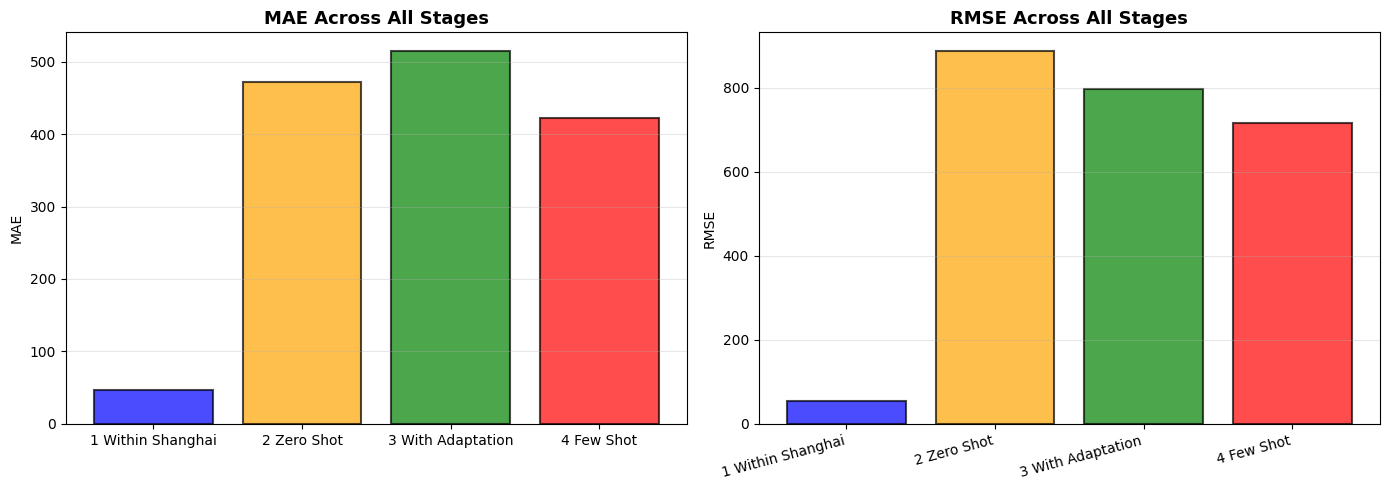

💾 Results saved to: /content/drive/MyDrive/Escalator_Control_Models/cross_dataset_evaluation_results.txt

✨ 4-STAGE EVALUATION COMPLETE ✨

📌 KEY INSIGHTS:
   • Stage 1 (Intra-domain): Baseline model quality
   • Stage 2 (Zero-shot): Your current approach
   • Stage 3 (Adapted): Upper-bound with full data
   • Stage 4 (Few-shot): Practical with limited labels

💡 If Stage 2 ≈ Stage 3 → Good generalization!
💡 If Stage 2 << Stage 3 → Domain gap (expected)


In [19]:
# Cell 16: COMPREHENSIVE 4-STAGE CROSS-DATASET EVALUATION (FINAL)

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os

class CrossDatasetEvaluator:
    """
    4-STAGE EVALUATION PIPELINE:
    ✅ Stage 1: Intra-domain (Part A → Part B)
    ✅ Stage 2: Zero-shot (Shanghai A+B → JHU test)
    ✅ Stage 3: Domain adaptation (fine-tune on full JHU train)
    ✅ Stage 4: Few-shot (fine-tune on 10% JHU train)
    """

    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.results = {}

    # =====================================================================
    # STAGE 1: Intra-Domain (Part A trained → Part B tested)
    # =====================================================================
    def stage1_within_shanghai(self):
        """Train on Part A, test on Part B (same dataset validation)"""
        print("\n" + "="*70)
        print("🔍 STAGE 1: INTRA-DOMAIN EVALUATION (Part A → Part B)")
        print("="*70)

        partB_test = CrowdDataset(
            data_dir=Config.PART_B_PATH,
            mode="test",
            dataset_type="shanghai"
        )

        partB_test_loader = DataLoader(
            partB_test,
            batch_size=4,
            shuffle=False,
            num_workers=0,
            pin_memory=(self.device.type == "cuda")
        )

        metrics = self._compute_metrics(partB_test_loader)
        self.results["stage1_within_shanghai"] = metrics

        print(f"\n✅ Part A Trained → Part B Tested")
        print(f"   MAE:  {metrics['mae']:.2f}")
        print(f"   RMSE: {metrics['rmse']:.2f}")
        print(f"   MRE:  {metrics['mre']:.1f}%")
        print(f"   R²:   {metrics['r_squared']:.3f}")

        return metrics

    # =====================================================================
    # STAGE 2: Zero-Shot Generalization (Shanghai A+B → JHU test)
    # =====================================================================
    def stage2_zero_shot(self):
        """Your CURRENT approach: no fine-tuning on JHU"""
        print("\n" + "="*70)
        print("🎯 STAGE 2: ZERO-SHOT GENERALIZATION (Shanghai A+B → JHU test)")
        print("="*70)

        jhu_test = CrowdDataset(
            data_dir=Config.JHU_PATH,
            mode="test",
            dataset_type="jhu"
        )

        jhu_test_loader = DataLoader(
            jhu_test,
            batch_size=4,
            shuffle=False,
            num_workers=0,
            pin_memory=(self.device.type == "cuda")
        )

        metrics = self._compute_metrics(jhu_test_loader)
        self.results["stage2_zero_shot"] = metrics

        print(f"\n✅ Part A+B Trained → JHU Test (NO fine-tuning)")
        print(f"   MAE:  {metrics['mae']:.2f}")
        print(f"   RMSE: {metrics['rmse']:.2f}")
        print(f"   MRE:  {metrics['mre']:.1f}%")
        print(f"   R²:   {metrics['r_squared']:.3f}")

        return metrics

    # =====================================================================
    # STAGE 3: Domain Adaptation (fine-tune on full JHU train)
    # =====================================================================
    def stage3_with_adaptation(self, epochs=10, lr=1e-5):
        """Fine-tune on entire JHU train set"""
        print("\n" + "="*70)
        print("🔄 STAGE 3: DOMAIN ADAPTATION (Fine-tune on FULL JHU train)")
        print("="*70)

        jhu_train = CrowdDataset(
            data_dir=Config.JHU_PATH,
            mode="train",
            dataset_type="jhu"
        )

        jhu_test = CrowdDataset(
            data_dir=Config.JHU_PATH,
            mode="test",
            dataset_type="jhu"
        )

        train_loader = DataLoader(
            jhu_train,
            batch_size=4,
            shuffle=True,
            num_workers=0,
            pin_memory=(self.device.type == "cuda")
        )

        test_loader = DataLoader(
            jhu_test,
            batch_size=4,
            shuffle=False,
            num_workers=0,
            pin_memory=(self.device.type == "cuda")
        )

        # Fine-tune
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=lr
        )

        print(f"\n🔧 Fine-tuning for {epochs} epochs (lr={lr})")

        for ep in range(epochs):
            loss = self._finetune_epoch(train_loader, optimizer)
            print(f"   Epoch {ep+1}/{epochs} | Loss: {loss:.4f}")

        # Evaluate
        metrics = self._compute_metrics(test_loader)
        self.results["stage3_with_adaptation"] = metrics

        print(f"\n✅ After Fine-tuning (full JHU train)")
        print(f"   MAE:  {metrics['mae']:.2f}")
        print(f"   RMSE: {metrics['rmse']:.2f}")
        print(f"   MRE:  {metrics['mre']:.1f}%")
        print(f"   R²:   {metrics['r_squared']:.3f}")

        return metrics

    # =====================================================================
    # STAGE 4: Few-Shot (fine-tune on 10% JHU train)
    # =====================================================================
    def stage4_few_shot(self, fraction=0.1, epochs=5, lr=1e-5):
        """Fine-tune using only fraction of JHU training data"""
        print("\n" + "="*70)
        print(f"💡 STAGE 4: FEW-SHOT LEARNING (Fine-tune on {int(fraction*100)}% JHU train)")
        print("="*70)

        jhu_train_full = CrowdDataset(
            data_dir=Config.JHU_PATH,
            mode="train",
            dataset_type="jhu"
        )

        jhu_test = CrowdDataset(
            data_dir=Config.JHU_PATH,
            mode="test",
            dataset_type="jhu"
        )

        # Create subset
        subset_size = max(1, int(len(jhu_train_full) * fraction))
        subset_indices = np.random.choice(
            len(jhu_train_full),
            subset_size,
            replace=False
        )
        subset_dataset = torch.utils.data.Subset(
            jhu_train_full,
            subset_indices
        )

        subset_loader = DataLoader(
            subset_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=0,
            pin_memory=(self.device.type == "cuda")
        )

        test_loader = DataLoader(
            jhu_test,
            batch_size=4,
            shuffle=False,
            num_workers=0,
            pin_memory=(self.device.type == "cuda")
        )

        # Fine-tune
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=lr
        )

        print(f"\n🔧 Fine-tuning on {subset_size} samples, {epochs} epochs")

        for ep in range(epochs):
            loss = self._finetune_epoch(subset_loader, optimizer)
            print(f"   Epoch {ep+1}/{epochs} | Loss: {loss:.4f}")

        # Evaluate
        metrics = self._compute_metrics(test_loader)
        self.results["stage4_few_shot"] = metrics

        print(f"\n✅ After Few-Shot Fine-tuning ({int(fraction*100)}% of JHU train)")
        print(f"   MAE:  {metrics['mae']:.2f}")
        print(f"   RMSE: {metrics['rmse']:.2f}")
        print(f"   MRE:  {metrics['mre']:.1f}%")
        print(f"   R²:   {metrics['r_squared']:.3f}")

        return metrics

    # =====================================================================
    # UTILITIES
    # =====================================================================
    def _compute_metrics(self, loader):
        """Compute MAE, RMSE, MRE, R² on test loader"""
        self.model.eval()
        pred_counts = []
        true_counts = []

        with torch.no_grad():
            for images, gt_density in loader:
                images = images.to(self.device)
                gt_density = gt_density.to(self.device)

                # Multi-scale inference
                preds = None
                for s in Config.MULTISCALE_SCALES:
                    img_s = F.interpolate(
                        images,
                        scale_factor=s,
                        mode="bilinear",
                        align_corners=False
                    )
                    out = self.model(img_s)
                    out = F.interpolate(
                        out,
                        size=gt_density.shape[2:],
                        mode="bilinear",
                        align_corners=False
                    )
                    preds = out if preds is None else preds + out

                preds = preds / len(Config.MULTISCALE_SCALES)

                pred_counts.append(preds.sum().item())
                true_counts.append(gt_density.sum().item())

        pred_counts = np.array(pred_counts)
        true_counts = np.array(true_counts)

        mae = np.mean(np.abs(pred_counts - true_counts))
        rmse = np.sqrt(np.mean((pred_counts - true_counts) ** 2))
        mre = np.mean(
            np.abs(pred_counts - true_counts) / (true_counts + 1e-6)
        ) * 100

        ss_total = np.sum((true_counts - np.mean(true_counts)) ** 2)
        ss_res = np.sum((true_counts - pred_counts) ** 2)
        r2 = 1 - (ss_res / ss_total) if ss_total > 0 else 0.0

        return {
            "mae": float(mae),
            "rmse": float(rmse),
            "mre": float(mre),
            "r_squared": float(r2),
            "true_counts": true_counts,
            "pred_counts": pred_counts
        }

    def _finetune_epoch(self, loader, optimizer):
        """One fine-tuning epoch"""
        self.model.train()
        total_loss = 0

        for images, gt_density in loader:
            images = images.to(self.device)
            gt_density = gt_density.to(self.device)

            preds = self.model(images)
            gt_resized = F.interpolate(
                gt_density,
                size=preds.shape[2:],
                mode="bilinear",
                align_corners=False
            )

            loss = F.mse_loss(preds, gt_resized)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(loader)

    # =====================================================================
    # COMPARISON & VISUALIZATION
    # =====================================================================
    def compare_all_stages(self):
        """Print comparison table"""
        print("\n" + "="*80)
        print("📊 COMPREHENSIVE CROSS-DATASET EVALUATION SUMMARY")
        print("="*80)

        stages_order = [
            "stage1_within_shanghai",
            "stage2_zero_shot",
            "stage3_with_adaptation",
            "stage4_few_shot"
        ]

        print(f"\n{'Stage':<35} {'MAE':<10} {'RMSE':<10} {'MRE%':<10} {'R²':<10}")
        print("-" * 80)

        for stage in stages_order:
            if stage not in self.results:
                continue

            m = self.results[stage]
            stage_name = {
                "stage1_within_shanghai": "Intra-Domain (A→B)",
                "stage2_zero_shot": "Zero-Shot (A+B→JHU)",
                "stage3_with_adaptation": "Adapted (Full JHU)",
                "stage4_few_shot": "Few-Shot (10% JHU)"
            }[stage]

            print(
                f"{stage_name:<35} {m['mae']:<10.2f} "
                f"{m['rmse']:<10.2f} {m['mre']:<10.1f} {m['r_squared']:<10.3f}"
            )

        print("="*80)

    def plot_comparison(self):
        """Visualize all 4 stages"""
        if not self.results:
            print("⚠️ No results to visualize")
            return

        stages = []
        maes = []
        rmses = []

        for s in ["stage1_within_shanghai", "stage2_zero_shot",
                  "stage3_with_adaptation", "stage4_few_shot"]:
            if s in self.results:
                stages.append(s.replace("stage", "").replace("_", " ").title())
                maes.append(self.results[s]["mae"])
                rmses.append(self.results[s]["rmse"])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        colors = ["blue", "orange", "green", "red"][:len(stages)]

        ax1.bar(stages, maes, color=colors, alpha=0.7, edgecolor="black", linewidth=1.5)
        ax1.set_title("MAE Across All Stages", fontsize=13, fontweight="bold")
        ax1.set_ylabel("MAE")
        ax1.grid(axis="y", alpha=0.3)

        ax2.bar(stages, rmses, color=colors, alpha=0.7, edgecolor="black", linewidth=1.5)
        ax2.set_title("RMSE Across All Stages", fontsize=13, fontweight="bold")
        ax2.set_ylabel("RMSE")
        ax2.grid(axis="y", alpha=0.3)

        plt.xticks(rotation=15, ha="right")
        plt.tight_layout()
        plt.show()

    def save_results(self, save_path=None):
        """Save evaluation results to file"""
        if save_path is None:
            save_path = os.path.join(
                Config.SAVE_DIR,
                "cross_dataset_evaluation_results.txt"
            )

        with open(save_path, "w") as f:
            f.write("="*80 + "\n")
            f.write("CROSS-DATASET EVALUATION RESULTS\n")
            f.write("="*80 + "\n\n")

            for stage, metrics in self.results.items():
                f.write(f"{stage.upper()}\n")
                f.write(f"  MAE:  {metrics['mae']:.2f}\n")
                f.write(f"  RMSE: {metrics['rmse']:.2f}\n")
                f.write(f"  MRE:  {metrics['mre']:.1f}%\n")
                f.write(f"  R²:   {metrics['r_squared']:.3f}\n\n")

        print(f"💾 Results saved to: {save_path}")


# ===========================================================================
# RUN COMPREHENSIVE 4-STAGE EVALUATION
# ===========================================================================
print("\n🚀 INITIATING COMPREHENSIVE CROSS-DATASET EVALUATION")
print("="*80)

evaluator = CrossDatasetEvaluator(model, device)

# Stage 1: Intra-domain
evaluator.stage1_within_shanghai()

# Stage 2: Zero-shot
evaluator.stage2_zero_shot()

# Stage 3: Domain adaptation
evaluator.stage3_with_adaptation(epochs=10, lr=1e-5)

# Stage 4: Few-shot
evaluator.stage4_few_shot(fraction=0.1, epochs=5, lr=1e-5)

# Compare & visualize
evaluator.compare_all_stages()
evaluator.plot_comparison()
evaluator.save_results()

print("\n✨ 4-STAGE EVALUATION COMPLETE ✨")
print("\n📌 KEY INSIGHTS:")
print("   • Stage 1 (Intra-domain): Baseline model quality")
print("   • Stage 2 (Zero-shot): Your current approach")
print("   • Stage 3 (Adapted): Upper-bound with full data")
print("   • Stage 4 (Few-shot): Practical with limited labels")
print("\n💡 If Stage 2 ≈ Stage 3 → Good generalization!")
print("💡 If Stage 2 << Stage 3 → Domain gap (expected)")